In [1]:
from brainnet.config import get_cfg_defaults

cfg = get_cfg_defaults()

# manually download and unzip subj01.zip from algonauts2023 challenge
# https://docs.google.com/forms/d/e/1FAIpQLSehZkqZOUNk18uTjRTuLj7UYmRGz-OkdsU25AyO3Wm6iAb0VA/viewform
cfg.DATASET.DATA_DIR = "/data/download/alg23/subj01"

In [2]:
import torch
from torch import nn
import numpy as np
from einops import rearrange
from dinov2.models.vision_transformer import DinoVisionTransformer


"""
get_tokens() need to be implemented by user.
"""
class ModifiedDiNOv2(nn.Module):
    def __init__(self, ver="dinov2_vitb14", **kwargs) -> None:
        super().__init__()
        vision_model = torch.hub.load("facebookresearch/dinov2", ver)
        self.vision_model: DinoVisionTransformer = vision_model
        self.vision_model.requires_grad_(False)
        self.vision_model.eval()

    def get_tokens(
        self,
        x,
    ):
        #### original code #### begin
        x = self.vision_model.prepare_tokens_with_masks(x)
        #### original code #### end

        #### modified code #### begin
        local_tokens = {}
        global_tokens = {}
        for i, blk in enumerate(self.vision_model.blocks):
            x = blk(x)
            saved_x = x.clone()
            global_tokens[str(i)] = saved_x[:, 0, :]  # [B, C]
            saved_x = saved_x[:, 1:, :]  # remove cls token, [B, N, C]
            p = int(np.sqrt(saved_x.shape[1]))
            saved_x = rearrange(saved_x, "b (p1 p2) c -> b c p1 p2", p1=p, p2=p)
            local_tokens[str(i)] = saved_x
        
        """
        return:
        local_tokens: dict, key: str, value: [B, C, H, W]
        global_tokens: dict, key: str, value: [B, C]
        """
        return local_tokens, global_tokens
    



In [3]:
# these 6 models are already implemented
# all of them are 12-layer 768-dim 
from brainnet.backbone import (
    ModifiedCLIP,
    ModifiedDiNOv2,
    ModifiedSAM,
    ModifiedImgNet,
    ModifiedMAE,
    ModifiedMoCov3,
)
backbone = ModifiedCLIP()
cfg.MODEL.LAYERS = list(range(12))
cfg.MODEL.LAYER_WIDTHS = [768] * len(cfg.MODEL.LAYERS)
cfg.MODEL.BOTTLENECK_DIM = 128  # can be reduced to speed up

In [10]:
from brainnet.plmodel import PLModel
import pytorch_lightning as pl


plmodel = PLModel(cfg, backbone, draw=True)
# plmodel.validation_epoch_end() is called on validation epoch to draw
plmodel = plmodel.cuda()

/usr/local/lib/python3.8/site-packages/cortex/utils.py:1023: UserWarning: fsaverage is already present in the database. Set download_again to True if you wish to download the subject again.
  warnings.warn(


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/workspace/brainnet/plot_utils.py:308: RuntimeWarning: invalid value encountered in divide
  fsaverage /= 0  # nan to make other vertices transparent
/usr/local/lib/python3.8/site-packages/cortex/dataset/viewRGB.py:582: RuntimeWarning: invalid value encountered in cast
  vert = (np.clip(vert, 0, 1) * 255).astype(np.uint8)
/workspace/brainnet/plot_utils.py:258: RuntimeWarning: invalid value encountered in divide
  fsaverage /= 0  # nan to make other vertices transparent
/workspace/brainnet/plot_utils.py:353: RuntimeWarning: invalid value encountered in divide
  fsaverage /= 0  # nan to make other vertices transparent


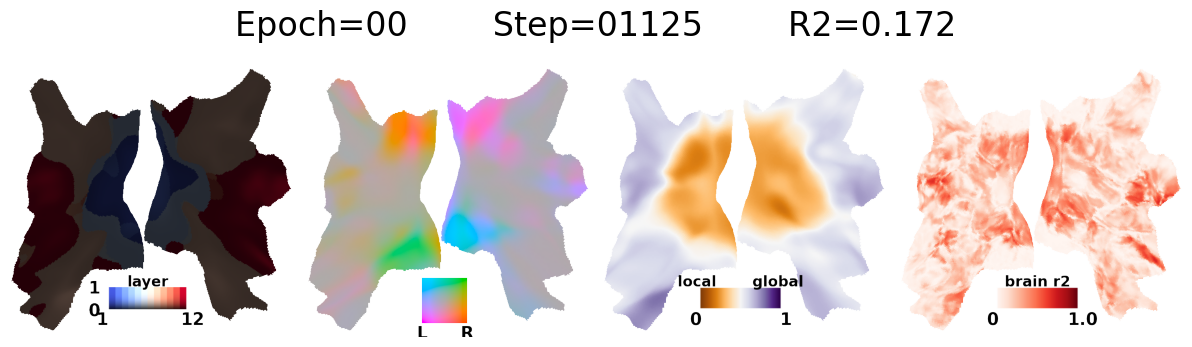

Validation: 0it [00:00, ?it/s]

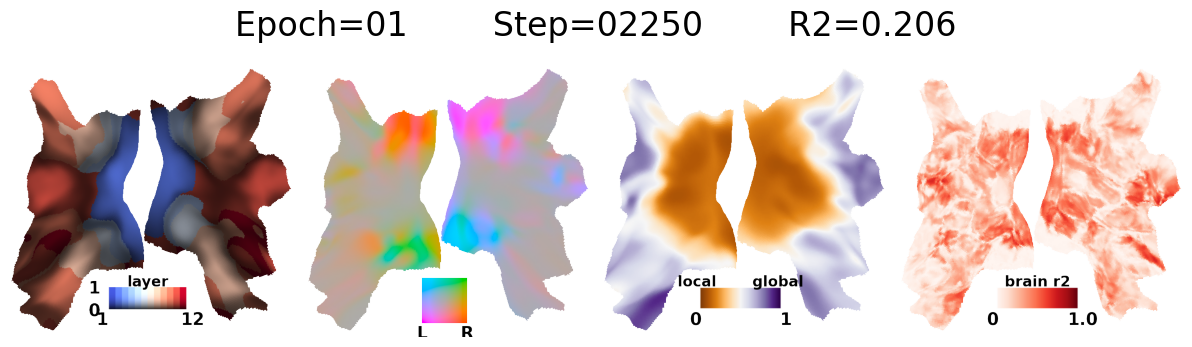

Validation: 0it [00:00, ?it/s]

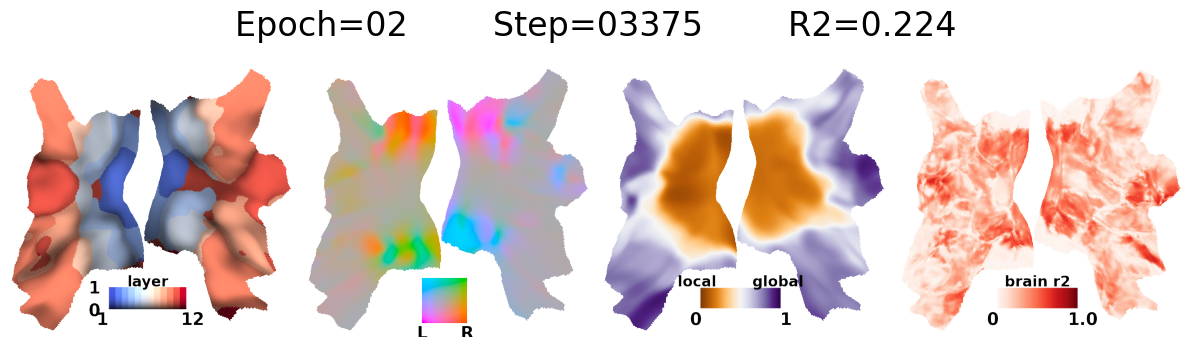

Validation: 0it [00:00, ?it/s]

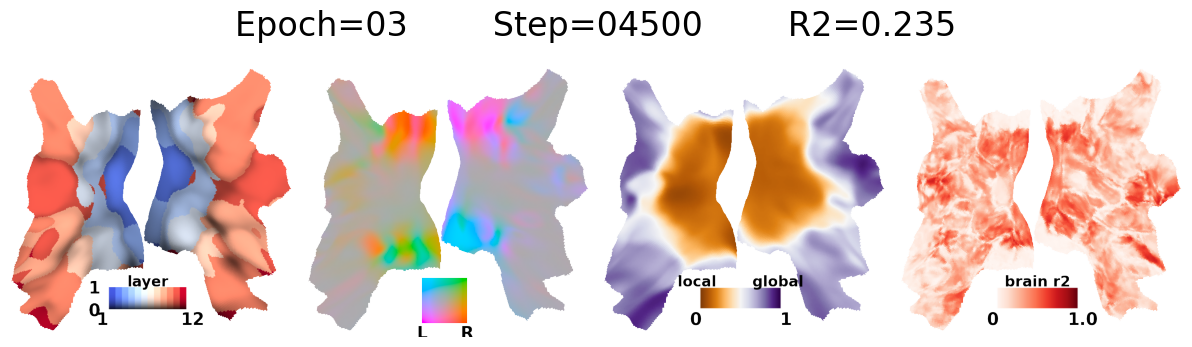

Validation: 0it [00:00, ?it/s]

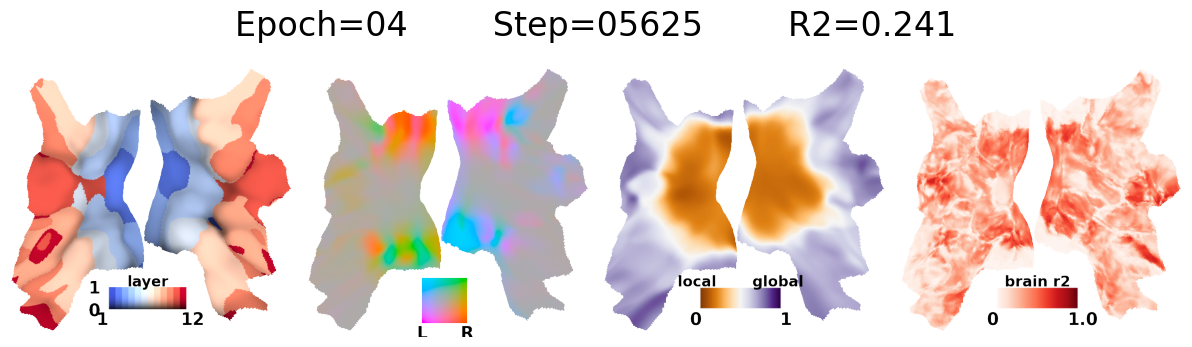

Validation: 0it [00:00, ?it/s]

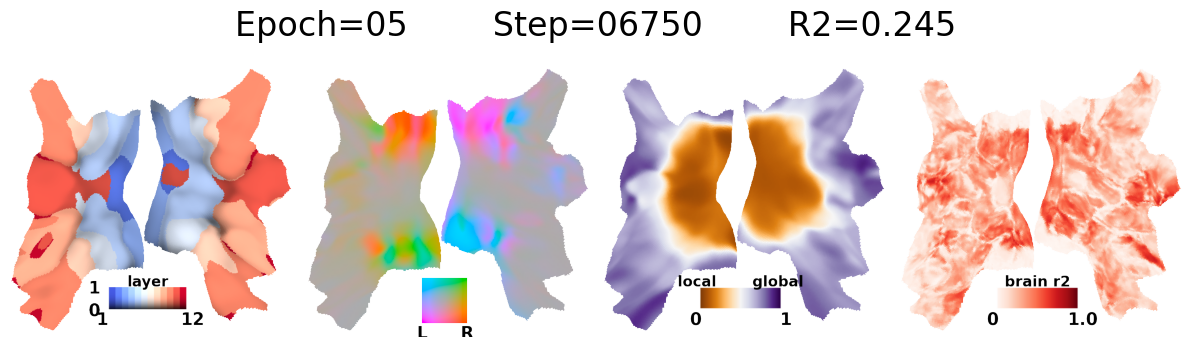

Validation: 0it [00:00, ?it/s]

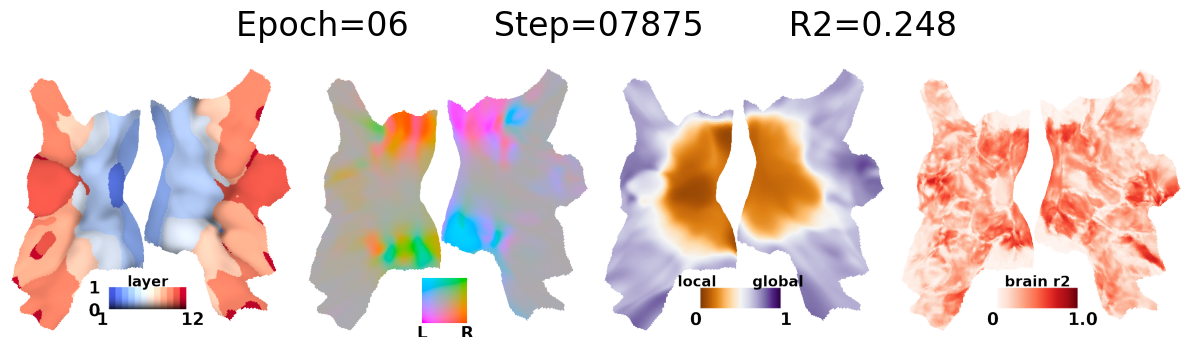

Validation: 0it [00:00, ?it/s]

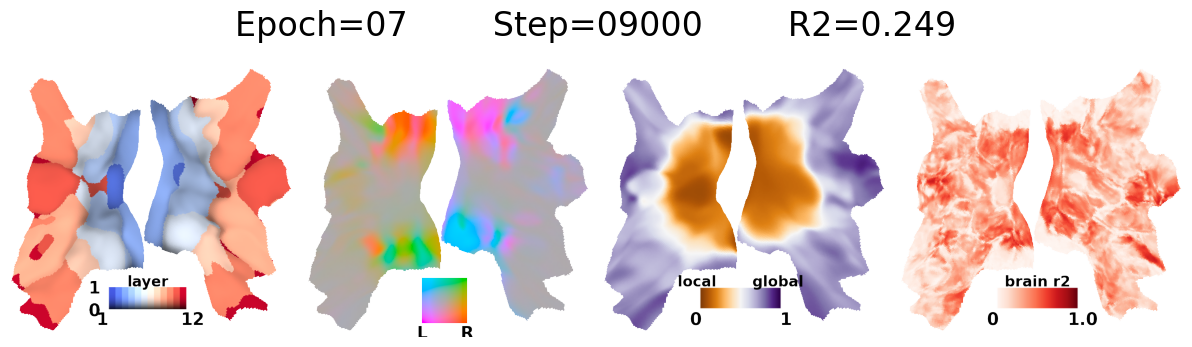

Validation: 0it [00:00, ?it/s]

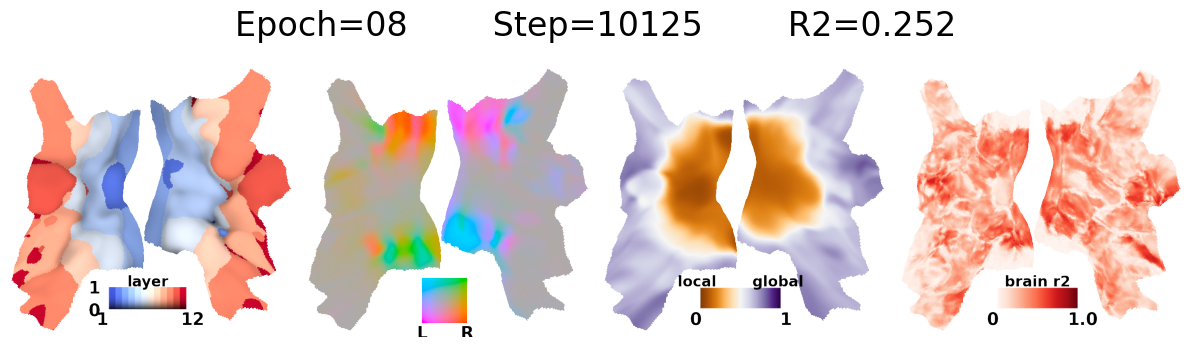

Validation: 0it [00:00, ?it/s]

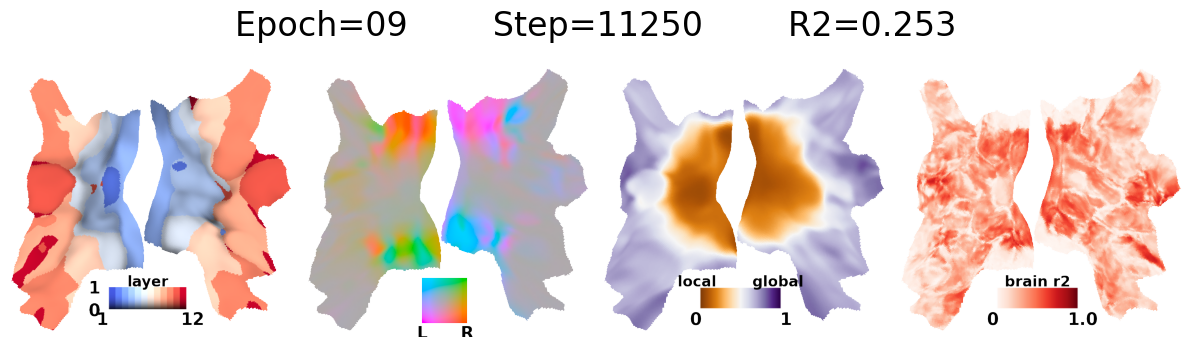

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


on_fit_end: running clustering channels


used 48 iterations (34.4997s) to cluster 37984 items into 1000 clusters


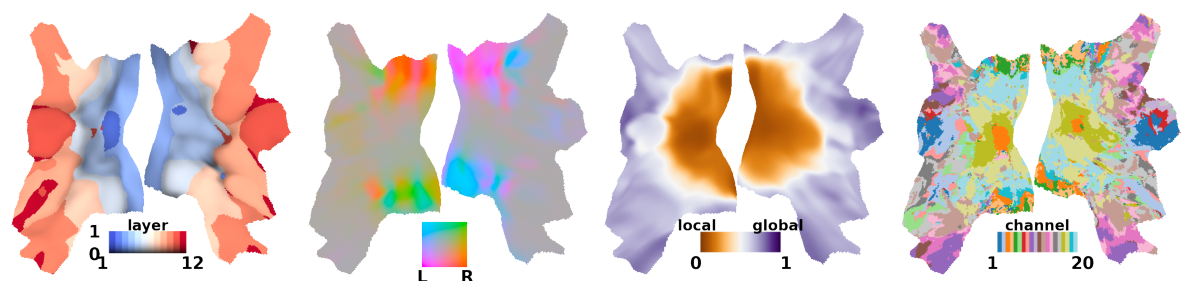

In [11]:
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=[0],
    gradient_clip_val=0.5,
    precision=16,
    limit_train_batches=1.0,
    limit_val_batches=1.0,
    enable_checkpointing=False,
)
trainer.fit(plmodel)
# 30 min on 4090, 8GB of VRAM

/workspace/brainnet/plot_utils.py:353: RuntimeWarning: invalid value encountered in divide
  fsaverage /= 0  # nan to make other vertices transparent


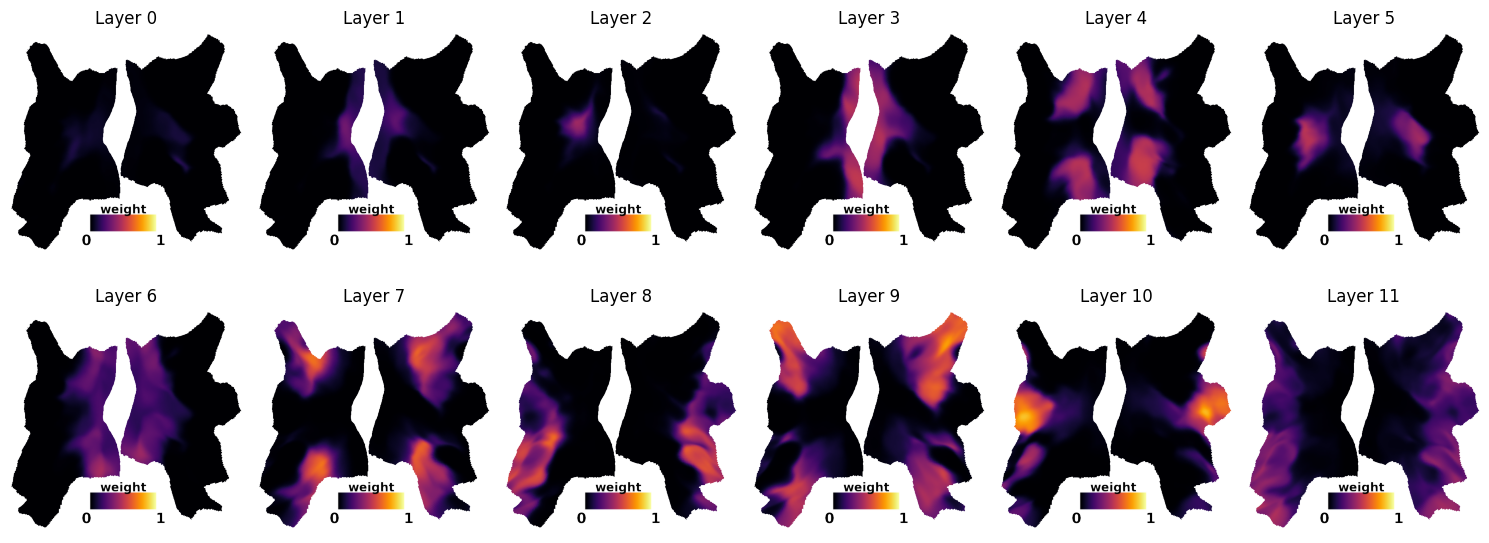

In [7]:
# plot raw layer selector weights
import matplotlib.pyplot as plt

sel_space, sel_layer, sel_scale = plmodel.get_selectors()
sel_layer = sel_layer.detach().cpu().numpy()
from brainnet.plot_utils import make_single_ls_weight_plot

for i in range(12):
    png = f"/tmp/ls_weight_{i}.png"
    make_single_ls_weight_plot(sel_layer[:, i], png)
fig, axs = plt.subplots(2, 6, figsize=(15, 6))
for i in range(12):
    ax = axs.flatten()[i]
    ax.set_title(f"Layer {i}")
    png = f"/tmp/ls_weight_{i}.png"
    ax.imshow(plt.imread(png))
    ax.axis("off")
fig.tight_layout()
plt.show()
plt.close()

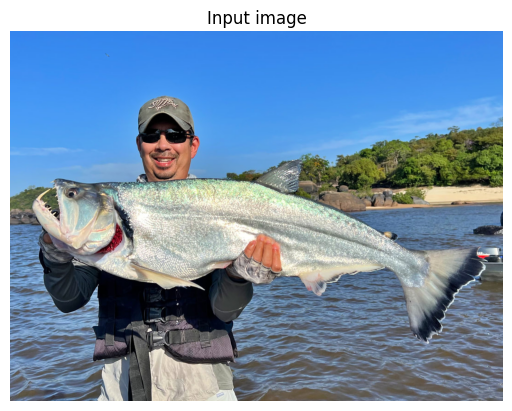

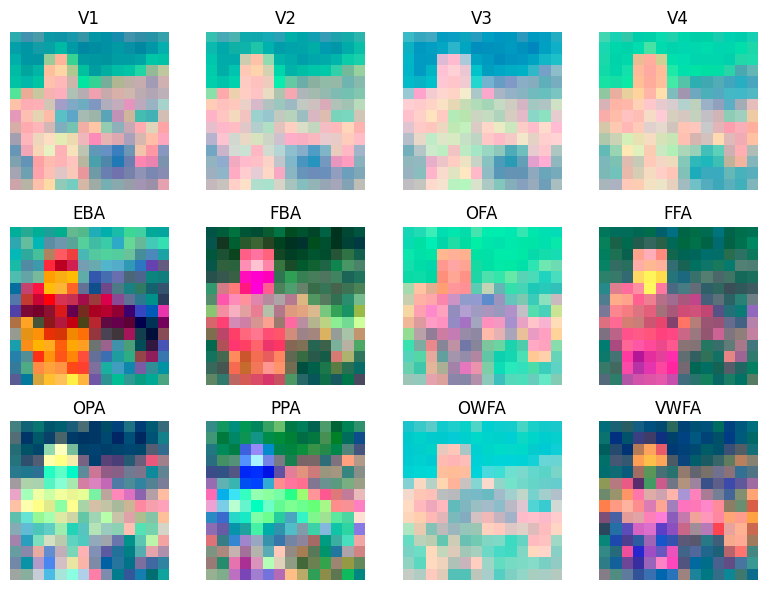

In [9]:
## plot top channels

from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

image_path = "/workspace/assets/catchafish.jpg"
plt.imshow(Image.open(image_path))
plt.axis("off")
plt.title("Input image")
plt.show()
plt.close()

image = Image.open(image_path).convert("RGB")
transforms = transforms.Compose(
    [
        transforms.Resize(cfg.DATASET.RESOLUTION),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
image = transforms(image).unsqueeze(0).cuda()

top_channels = plmodel.draw_top_channels(image)